In [1]:
import os
#import cv2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.metrics import accuracy_score
from skimage import transform
from sklearn.neighbors import NearestNeighbors

from sklearn import neighbors

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.svm import LinearSVC 


In [4]:
filename = "image_labels_level_0.txt"
data = []
f = open(filename, "r")
data = f.readlines()
f.close()
data
for i in range(len(data)):
    data[i] = data[i].replace("\t", " ")
#     data[i] = data[i].replace("", " ")
    data[i] = data[i].replace("\n", "")
    data[i] = str.split(data[i],' ')
sorted_data = [value for index, value in sorted(enumerate(data), key=lambda data:data[1])]
cols = ["image_id", "split_id", "shape_id"]
df_image_0 = pd.DataFrame(sorted_data, columns = cols)
df_image_0.head(5)

,image_id,split_id,shape_id
0,00001,1,1
1,00002,1,1
2,00003,1,1
3,00004,1,1
4,00005,1,"4,1"


In [5]:
filename = "image_labels_level_1.txt"
data = []
f = open(filename, "r")
data = f.readlines()
f.close()
for i in range(len(data)):
    data[i] = data[i].replace("\t", " ")
#     data[i] = data[i].replace(",", " ")
    data[i] = data[i].replace("\n", "")
    data[i] = str.split(data[i],' ')
sorted_data = [value for index, value in sorted(enumerate(data), key=lambda data:data[1])]
cols = ["image_id", "split_id", "sign_id"]
df_image_1 = pd.DataFrame(sorted_data, columns = cols)
df_image_1.head(5)

,image_id,split_id,sign_id
0,00001,1,18
1,00002,1,18
2,00003,1,18
3,00004,1,18
4,00005,1,"30,9"


In [6]:
filename = "object_labels_level_0.txt"
data = []
f = open(filename, "r")
data = f.readlines()
f.close()
for i in range(len(data)):
    data[i] = data[i].replace("\t", " ")
    data[i] = data[i].replace(",", " ")
    data[i] = data[i].replace("\n", "")
    data[i] = str.split(data[i],' ')
sorted_data = [value for index, value in sorted(enumerate(data), key=lambda data:data[1])]
cols = ["image_id", "shape_id", "x", "y", "height", "width"]
df_object_0 = pd.DataFrame(sorted_data, columns = cols)
# df_object_0.head(15)


In [7]:
filename = "object_labels_level_1.txt"
data = []
f = open(filename, "r")
data = f.readlines()
f.close()
for i in range(len(data)):
    data[i] = data[i].replace("\t", " ")
    data[i] = data[i].replace(",", " ")
    data[i] = data[i].replace("\n", "")
    data[i] = str.split(data[i],' ')
sorted_data = [value for index, value in sorted(enumerate(data), key=lambda data:data[1])]
cols = ["image_id", "sign_id", "x", "y", "height", "width"]
df_object_1 = pd.DataFrame(sorted_data, columns = cols)
# df_object_1.head(15)


In [8]:
df_image = pd.merge(df_image_0, df_image_1, how = "inner", on = ['image_id', 'split_id'])
df_image.head(25)

,image_id,split_id,shape_id,sign_id
0,00001,1,1,18
1,00002,1,1,18
2,00003,1,1,18
3,00004,1,1,18
4,00005,1,"4,1","30,9"
5,00006,1,"4,1","30,9"
6,00007,1,"10,4,1","80,30,9"
7,00008,1,10,80
8,00009,1,10,80
9,00010,1,"10,4,1","80,30,9"


In [10]:
df_object = pd.merge(df_object_0, df_object_1, how = "inner", on = ['image_id', 'x', 'y', 'height', 'width'])
order = ["image_id", "shape_id", "sign_id", "x", "y", "height", "width"]
df_object = df_object[order]
df_object.head(6)

,image_id,shape_id,sign_id,x,y,height,width
0,00001,1,18,413,261,18,15
1,00002,1,18,452,248,35,32
2,00003,1,18,488,231,46,41
3,00004,1,18,635,170,86,87
4,00005,1,9,421,251,23,21
5,00005,4,30,426,273,16,18


In [ ]:
filenames = []
for filename in os.listdir("images"):
    filenames.append(filename)
filenames.sort()
filenames

In [12]:
length = len(filenames)
train_objects = []
train_shape = []
train_sign = []
test_objects = []
test_shape = []
test_sign = []
count = 0
# m = 0
# ob = 0
# im = 0
for i in range(length):
    s = "images/" + filenames[i]
    img = Image.open(s, "r")#.convert('L')
    img_name = df_image["image_id"][i]
    if len(df_object[df_object["image_id"] == img_name]) == 0:
           continue
    index = df_object[df_object["image_id"] == img_name].index[0]
#     index = df_object[df_object["image_id"] == img_name].index[0]
    number = df_image.iat[i,2].count(',') + 1    # count the number of objects contained in one image
    if df_image.iat[i,1] == "1":      # split trainset and testset, "1" for training, "0" for testing
        for j in range(number):
            # crop image
            a = int(df_object["x"][index+j])
            b = int(df_object["y"][index+j])
            c = int(df_object["height"][index+j]) + a
            d = int(df_object["width"][index+j]) + b
            CropImg = img.crop((a,b,c,d))
            CropImg = CropImg.resize((32,32))
            CropImg = np.array(CropImg)
#             if max(CropImg.shape) > m:
#                 m = max(CropImg.shape)
#                 im = i
#                 ob = count
#             CropImg = CropImg.reshape(3072)
            train_objects.append(CropImg)                   # add image into trainset
            train_shape.append(df_object.iat[index+j,1])      # add its shape id
            train_sign.append(df_object.iat[index+j,2])       # add its sign id
            
            
    elif df_image.iat[i,1] == "0":      # process testset
        for j in range(number):
            # crop image
            a = int(df_object["x"][index+j])
            b = int(df_object["y"][index+j])
            c = int(df_object["height"][index+j]) + a
            d = int(df_object["width"][index+j]) + b
            CropImg = img.crop((a,b,c,d))
            CropImg = CropImg.resize((32,32))
            CropImg = np.array(CropImg)
#             CropImg = CropImg.reshape(3072)
#             if max(CropImg.shape) > m:
#                 m = max(CropImg.shape)
#                 im = i
#                 ob = count
            test_objects.append(CropImg)                   # add image into testset
            test_shape.append(df_object.iat[index+j,1])      # add its shape id
            test_sign.append(df_object.iat[index+j,2])       # add its sign id
            
# transform to numpy array
train_objects = np.array(train_objects)
train_shape = np.array(train_shape)
train_sign = np.array(train_sign)
test_objects = np.array(test_objects)
test_shape = np.array(test_shape)
test_sign = np.array(test_sign)

In [15]:
for i in range(train_objects.shape[0]):
    temp_object = train_objects[i,:,:,:]
    mean = np.mean(temp_object)
    std = np.max([np.std(temp_object), 1.0 / np.sqrt(train_objects.shape[1] * train_objects.shape[2] * train_objects.shape[3])])
    train_objects[i,:,:,:] = (temp_object - mean) / std

In [16]:
for i in range(test_objects.shape[0]):
    temp_object = test_objects[i,:,:,:]
    mean = np.mean(temp_object)
    std = np.max([np.std(temp_object), 1.0 / np.sqrt(test_objects.shape[1] * test_objects.shape[2] * train_objects.shape[3])])
    test_objects[i,:,:,:] = (temp_object - mean) / std

In [19]:
train_objects=np.array(train_objects)
train_objects.shape

(1904, 32, 32, 3)

In [20]:
img = Image.open('images/00001.png').convert('L')
np.array(img).reshape(1,576*720)

array([[117, 116, 115, ..., 159, 158, 160]], dtype=uint8)

In [23]:
#read & transfrom to grayscale images
length = len(filenames)
train_objects = []
train_shape = []
train_sign = []
test_objects = []
test_shape = []
test_sign = []
count = 0
# m = 0
# ob = 0
# im = 0
for i in range(length):
    s = "images/" + filenames[i]
    img = Image.open(s, "r").convert('L')
    img_name = df_image["image_id"][i]
#     if len(df_object[df_object["image_id"] == img_name]) == 0:
#            continue
#     index = df_object[df_object["image_id"] == img_name].index[0]
#     index = df_object[df_object["image_id"] == img_name].index[0]
    number = len(df_object[df_object["image_id"] == img_name])
    if number == 0:
        continue;
    index = df_object[df_object["image_id"] == img_name].index[0]
#     number = df_image.iat[i,2].count(',') + 1    # count the number of objects contained in one image
    if df_image.iat[i,1] == "1":      # split trainset and testset, "1" for training, "0" for testing
        for j in range(number):
            # crop image
            a = int(df_object["x"][index+j])
            b = int(df_object["y"][index+j])
            c = int(df_object["height"][index+j]) + a
            d = int(df_object["width"][index+j]) + b
            CropImg = img.crop((a,b,c,d))
            CropImg = CropImg.resize((24,24))
            CropImg = np.array(CropImg)
            CropImg = CropImg.reshape(576)
            train_objects.append(CropImg)                   # add image into trainset
            train_shape.append(df_object.iat[index+j,1])      # add its shape id
            train_sign.append(df_object.iat[index+j,2])       # add its sign id
            
            
    elif df_image.iat[i,1] == "0":      # process testset
        for j in range(number):
            # crop image
            a = int(df_object["x"][index+j])
            b = int(df_object["y"][index+j])
            c = int(df_object["height"][index+j]) + a
            d = int(df_object["width"][index+j]) + b
            CropImg = img.crop((a,b,c,d))
            CropImg = CropImg.resize((24,24))
            CropImg = np.array(CropImg)
            CropImg = CropImg.reshape(576)
            test_objects.append(CropImg)                   # add image into testset
            test_shape.append(df_object.iat[index+j,1])      # add its shape id
            test_sign.append(df_object.iat[index+j,2])       # add its sign id
            
# transform to numpy array
train_objects = np.array(train_objects)
train_shape = np.array(train_shape)
train_sign = np.array(train_sign)
test_objects = np.array(test_objects)
test_shape = np.array(test_shape)
test_sign = np.array(test_sign)


In [62]:
#svc
#shape
#linear svm  model train
clf = svm.SVC(C=1, kernel='linear', decision_function_shape='ovr')
clf.fit(train_objects, train_shape)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [63]:
#shape accuracy (train)
clf.score(train_objects, train_shape)

1.0

In [64]:
#shape accuracy (test)
clf.score(test_objects, test_shape)

0.8658008658008658

[10  6 10 10  6  7  6 10  7  1  1 10  6  1  4 10  1  1  7  3]
[ 4  6 10 10  6  7  6 10  7  1  1 10  6  1  4 10  1  1  7  3]


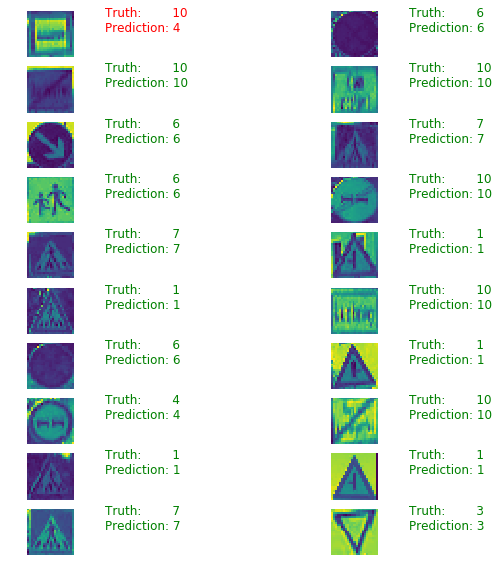

In [68]:
import random
# global prediction
predictedSVM=clf.predict(test_objects)
sample_indexes = random.sample(range(len(test_objects)), 20)
sample_images = [test_objects[i] for i in sample_indexes]
sample_labels = [test_shape[i] for i in sample_indexes]
sample_labels = np.array(sample_labels)
sample_labels = sample_labels.astype(int)
predicted_labels = [predictedSVM[i] for i in sample_indexes]
predicted_labels = np.array(predicted_labels)
predicted_labels = predicted_labels.astype(int)
# Run the "predicted_labels" op.
# sess.run(tf.global_variables_initializer())
# predicted_test = sess.run(predicted, feed_dict={xs: sample_images})
# a = tf.arg_max(predicted_test,1)
print(sample_labels)
print(predicted_labels)

fig = plt.figure(figsize=(10, 10))
for i in range(len(sample_images)):
    truth = sample_labels[i]
    prediction = predicted_labels[i]
    plt.subplot(10, 2,1+i)
    plt.axis('off')
    c='green' if truth == prediction else 'red'
    plt.text(40, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction), 
             fontsize=12, color=c)
    plt.imshow(test_objects[sample_indexes[i]].reshape(24,24))

In [57]:
#svm
#sign
#linear svm  model train
clf = svm.SVC(C=1, kernel='linear', decision_function_shape='ovr')
clf.fit(train_objects,train_sign)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [58]:
#sign accuracy (train)
clf.score(train_objects,train_sign)

1.0

In [59]:
#sign accuracy (test)
clf.score(test_objects,test_sign)

0.6845238095238095

In [144]:
clf.predict(test_objects)

array(['44', '44', '85', ..., '31', '29', '31'], dtype='<U2')

In [ ]:
import random
# global prediction
predictedSVM=clf.predict(test_objects)
sample_indexes = random.sample(range(len(test_objects)), 20)
sample_images = [test_objects[i] for i in sample_indexes]
sample_labels = [test_sign[i] for i in sample_indexes]
sample_labels = np.array(sample_labels)
sample_labels = sample_labels.astype(int)
predicted_labels = [predictedSVM[i] for i in sample_indexes]
predicted_labels = np.array(predicted_labels)
predicted_labels = predicted_labels.astype(int)
# Run the "predicted_labels" op.
# sess.run(tf.global_variables_initializer())
# predicted_test = sess.run(predicted, feed_dict={xs: sample_images})
# a = tf.arg_max(predicted_test,1)
print(sample_labels)
print(predicted_labels)

fig = plt.figure(figsize=(10, 10))
for i in range(len(sample_images)):
    truth = sample_labels[i]
    prediction = predicted_labels[i]
    plt.subplot(10, 2,1+i)
    plt.axis('off')
    c='green' if truth == prediction else 'red'
    plt.text(40, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction), 
             fontsize=12, color=c)
    plt.imshow(test_objects[sample_indexes[i]].reshape(24,24))

In [21]:
#read images
length = len(filenames)
train_objects = []
train_shape = []
train_sign = []
test_objects = []
test_shape = []
test_sign = []
count = 0
# m = 0
# ob = 0
# im = 0
for i in range(length):
    s = "images/" + filenames[i]
    img = Image.open(s, "r")#.convert('L')
    img_name = df_image["image_id"][i]
#     if len(df_object[df_object["image_id"] == img_name]) == 0:
#            continue
#     index = df_object[df_object["image_id"] == img_name].index[0]
#     index = df_object[df_object["image_id"] == img_name].index[0]
    number = len(df_object[df_object["image_id"] == img_name])
    if number == 0:
        continue;
    index = df_object[df_object["image_id"] == img_name].index[0]
#     number = df_image.iat[i,2].count(',') + 1    # count the number of objects contained in one image
    if df_image.iat[i,1] == "1":      # split trainset and testset, "1" for training, "0" for testing
        for j in range(number):
            # crop image
            a = int(df_object["x"][index+j])
            b = int(df_object["y"][index+j])
            c = int(df_object["height"][index+j]) + a
            d = int(df_object["width"][index+j]) + b
            CropImg = img.crop((a,b,c,d))
            CropImg = CropImg.resize((24,24))
            CropImg = np.array(CropImg)
            CropImg = CropImg.reshape(1728)
            train_objects.append(CropImg)                   # add image into trainset
            train_shape.append(df_object.iat[index+j,1])      # add its shape id
            train_sign.append(df_object.iat[index+j,2])       # add its sign id
            
            
    elif df_image.iat[i,1] == "0":      # process testset
        for j in range(number):
            # crop image
            a = int(df_object["x"][index+j])
            b = int(df_object["y"][index+j])
            c = int(df_object["height"][index+j]) + a
            d = int(df_object["width"][index+j]) + b
            CropImg = img.crop((a,b,c,d))
            CropImg = CropImg.resize((24,24))
            CropImg = np.array(CropImg)
            CropImg = CropImg.reshape(1728)
            test_objects.append(CropImg)                   # add image into testset
            test_shape.append(df_object.iat[index+j,1])      # add its shape id
            test_sign.append(df_object.iat[index+j,2])       # add its sign id
            
# transform to numpy array
train_objects = np.array(train_objects)
train_shape = np.array(train_shape)
train_sign = np.array(train_sign)
test_objects = np.array(test_objects)
test_shape = np.array(test_shape)
test_sign = np.array(test_sign)


In [22]:
#color shape

clf_color_shape = svm.SVC(C=0.8, kernel='rbf', gamma=20, decision_function_shape='ovr')
clf_color_shape.fit(train_objects, train_shape)

SVC(C=0.8, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=20, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [23]:
#shape accuracy(train)
clf_color_shape.score(train_objects, train_shape)

0.8904856293359762

In [24]:
#shape accuracy(test)
clf_color_shape.score(test_objects, test_shape)

0.3436147186147186

In [25]:
#color sign model train
clf_color_sign = svm.SVC(C=0.8, kernel='rbf', gamma=20, decision_function_shape='ovr')
clf_color_sign.fit(train_objects, train_sign)

SVC(C=0.8, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=20, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [26]:
#sign accuracy(train)
clf_color_sign.score(train_objects, train_sign)

0.6962338949454906

In [27]:
#sign accuracy(test)
clf_color_sign.score(test_objects, test_sign)

0.07088744588744589

In [105]:
# knn
#shape
knn = neighbors.KNeighborsClassifier(n_neighbors=5)
knn.fit(train_objects, train_shape)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [109]:
#shape accuracy(test)
predict = knn.predict(test_objects)
accuracy_score(predict,test_shape)

0.7813852813852814

In [102]:
#sign
knn = neighbors.KNeighborsClassifier(n_neighbors=5)

knn.fit(train_objects, train_sign)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [104]:
#sign accuracy(test)
predict_knn_sign = knn.predict(test_objects)
accuracy_score(predict_knn_sign,test_sign)

0.42478354978354976